In [14]:
import sys
sys.path.insert(0, './vONTSS/src/topicmodeling')
from vONTSS.src.topicmodeling.model import TopicModel

sys.path.append("..")
from ris_evaluation.evaluator import Evaluator

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [15]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

labels_df = pd.read_csv('../../datasets/data/BBC_News/labels.csv')
defined_keywords = [keywords.split(' ') for keywords in labels_df['class_keywords'].tolist()]

# First test

In [16]:
num_topic = len(set(labels))

topic_model = TopicModel(numb_embeddings=num_topic)
y_pred, y_pred_probas = topic_model.fit_transform(documents, index=defined_keywords)

In [17]:
model_output = {}
model_output['topics'] = [i[:topic_model.top_n_words] for i in topic_model.topics]
model_output['topic-word-matrix'] = topic_model.model.topics.get_topics().cpu().detach().numpy()
model_output['topic-document-matrix'] = topic_model.z.T

In [18]:
results_df = pd.DataFrame()
results_df['document'] = documents
results_df['y_true'] = documents_df['class_name'].tolist()
results_df['y_pred'] = y_pred_probas.argmax(axis=1)
results_df['y_pred_highest_proba'] = y_pred_probas.max(axis=1)

results_df

,document,y_true,y_pred,y_pred_highest_proba
0,hit shelf combine medium player phone gaming g...,tech,1,0.347074
1,bid hope join host apply host tournament aim r...,sport,1,0.300036
2,lord wrong detainee straw straw attack decisio...,politics,1,0.300292
3,leak answer minister explain budget detail pri...,politics,1,0.295656
4,delight manager pay tribute goal striker beat ...,sport,2,0.350196
...,...,...,...,...
2220,rock clean steer clear bad language front awar...,entertainment,1,0.267668
2221,comedy meet sequel meet parent top week movie ...,entertainment,1,0.287111
2222,join rare group actress nominate oscar star fo...,entertainment,1,0.274932
2223,police chief back move chief back introduction...,politics,1,0.289337


In [19]:
def get_words_for_topics(topics: list):
    """ Returns a dictionary with the words for each topic.

    Args:
        topics (list): List of topics. 
    
    Returns:
        dict: Dictionary with the words for each topic.
    """
    words_by_topics = {}
    for idx, topic in enumerate(topics):
        words = documents_df.iloc[idx]['document'].split()

        if topic not in words_by_topics:
            words_by_topics[topic] = {}

        for word in words:
            if word not in words_by_topics[topic]:
                words_by_topics[topic][word] = 0

            words_by_topics[topic][word] += 1

    return words_by_topics

In [20]:
evaluator = Evaluator(model_output)

words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
words_by_class = get_words_for_topics(results_df['y_true'].tolist())

In [21]:
coherence = evaluator.compute_coherence()
diversity = evaluator.compute_diversity()
supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

metrics_df = pd.DataFrame()

for coherence_type, coherence_value in coherence.items():
    metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
metrics_df['Diversity'] = [diversity]
metrics_df['Supervised correlation'] = [supervised_correlation]
metrics_df

IndexError: list index out of range

# Most important words

{0}


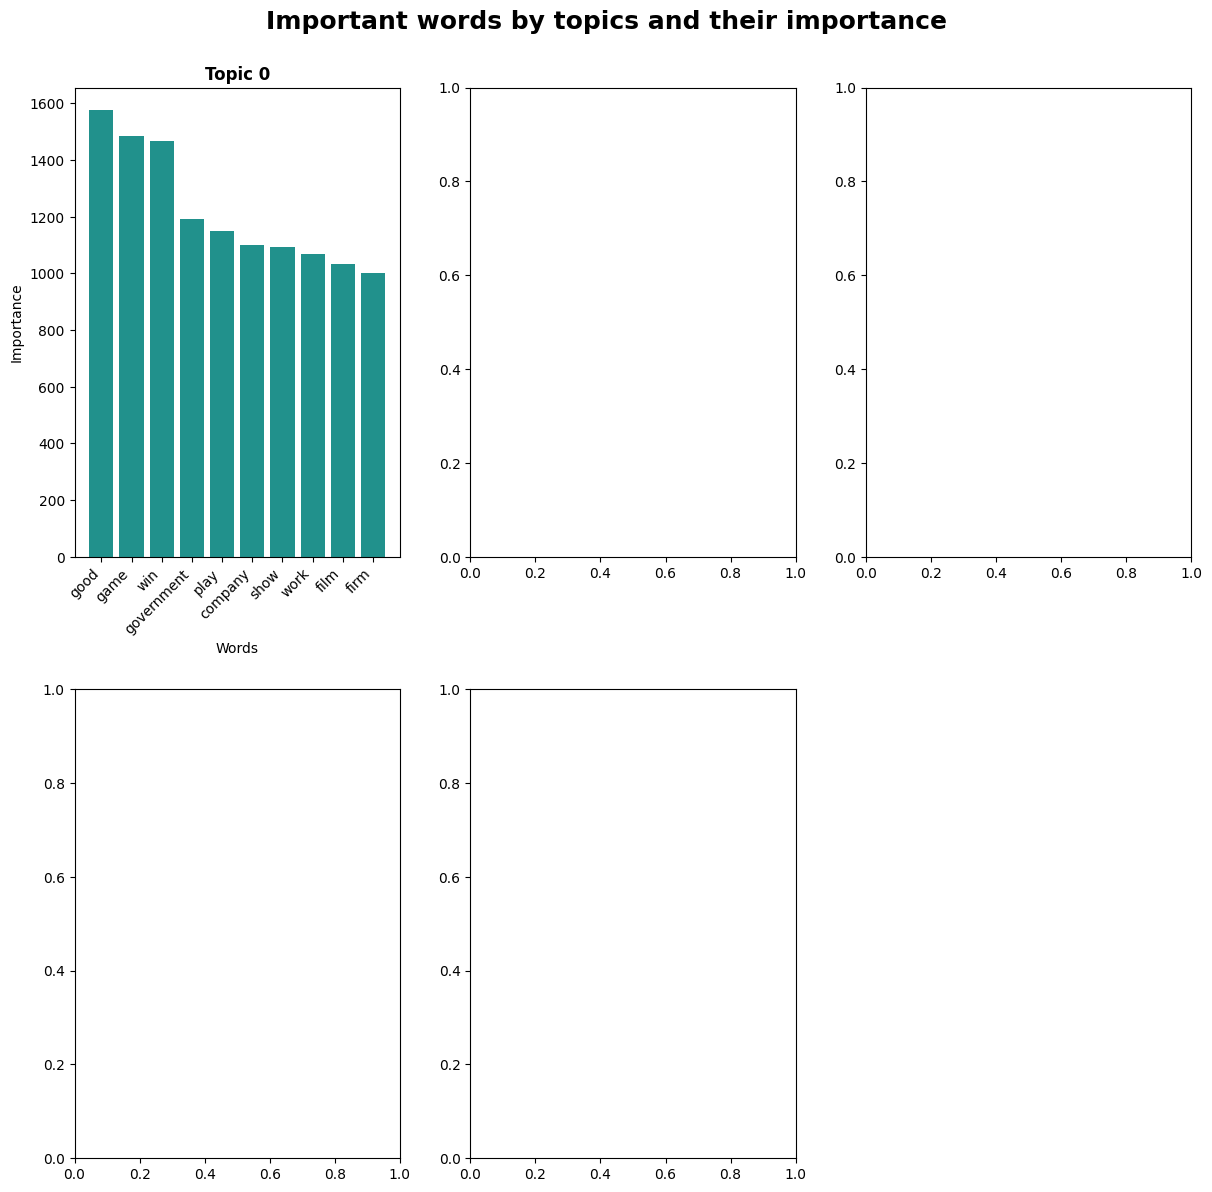

In [ ]:
no_top_words = 10
x, y = 0, 0
colors = sns.color_palette('viridis', n_colors=len(set(results_df['y_pred'].tolist())))

# Plotting the important words by topics and their importance
fig, axes = plt.subplots(2, 3, figsize=(12, 12))
fig.suptitle('Important words by topics and their importance', fontsize=18, fontweight='bold')

for topic_idx, topic in enumerate(set(results_df['y_pred'].tolist())):
    main_words = sorted(words_by_extracted_topics[topic].items(), key=lambda x: x[1], reverse=True)[:no_top_words]

    features = [x[0] for x in main_words]
    features_values = [x[1] for x in main_words]  

    ax = axes[x, y]
    ax.set_title(f'Topic {topic_idx}', fontsize=12, fontweight='bold')
    ax.bar(features, features_values, color=colors[topic_idx])
    ax.set_xlabel('Words')
    ax.set_ylabel('Importance')
    ax.xaxis.set_ticks(features)
    ax.set_xticklabels(features, rotation=45, ha='right')

    if y == 2:
        y = 0
        x += 1
    else:
        y += 1

fig.delaxes(axes[1, 2])
fig.tight_layout(pad=2.0, rect=[-0.02, -0.02, 1.02, 1])
fig.savefig('../../figures/vontss/important_words_by_topics.png')

# Randomness

In [23]:
n_iter = 5
metrics_df = pd.DataFrame()

for iter in range(n_iter):
    topic_model = TopicModel(numb_embeddings=num_topic)
    y_pred, y_pred_probas = topic_model.fit_transform(documents, index=defined_keywords)

    model_output = {}
    model_output['topics'] = [i[:topic_model.top_n_words] for i in topic_model.topics]
    model_output['topic-word-matrix'] = topic_model.model.topics.get_topics().cpu().detach().numpy()
    model_output['topic-document-matrix'] = topic_model.z.T

    results_df = pd.DataFrame()
    results_df['document'] = documents
    results_df['y_true'] = documents_df['class_name'].tolist()
    results_df['y_pred'] = y_pred_probas.argmax(axis=1)
    results_df['y_pred_highest_proba'] = y_pred_probas.max(axis=1)

    evaluator = Evaluator(model_output)

    words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
    words_by_class = get_words_for_topics(results_df['y_true'].tolist())

    coherence = evaluator.compute_coherence()
    diversity = evaluator.compute_diversity()
    supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

    metrics_df_iter = pd.DataFrame()

    for coherence_type, coherence_value in coherence.items():
        metrics_df_iter[f'Coherence ({coherence_type})'] = [coherence_value]
    metrics_df_iter['Diversity'] = [diversity]
    metrics_df_iter['Supervised correlation'] = [supervised_correlation]

    metrics_df = pd.concat([metrics_df, metrics_df_iter])

metrics_df = metrics_df.mean().to_frame().T
metrics_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.333155,-4.725737,-0.164438,-3.385126,0.972,0.28877
